In [10]:
from datetime import datetime
import glob

import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import matplotlib.ticker as mticker
import numpy as np

from helpers_plot import CDF
from helpers_data import thresholds, load_data

Function to plot histograms
---

In [16]:
def histogram(data, bins, ax=None, mask=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))
    
    dtimes = data.coords['time'].values
    data = data.values
    finite = np.isfinite(data)
    if mask is not None:
        finite = mask & finite
        
    data = np.ma.array(data, mask=finite)
    for row, dtime in zip(data, dtimes):
        row = row.data[row.mask]
        if not np.any(np.isfinite(row)):
            continue
        hist, bin_edges = np.histogram(row, bins=bins, density=False)
        hist = hist / np.nanmax(hist)

        corner_x = [dtime, dtime + np.timedelta64(27, 'D')]
        corner_y = bin_edges
        X, Y = np.meshgrid(corner_x, corner_y)
        hist = hist.reshape(hist.size, 1)

        im = ax.pcolormesh(X, Y, hist, norm=mcolor.LogNorm(vmin=0.01, vmax=1), cmap='Blues', rasterized=True)
        
    ax.set_xlabel('Year')
    if np.max(bins) > 180:
        # Set a better locator for longitude axis
        ax.yaxis.set_major_locator(mticker.FixedLocator([0, 90, 180, 270, 360]))
    return im

Load data
---

In [3]:
dates = {'kpvt': [datetime(1974, 1, 1), datetime(2003, 10, 7)],
         'mdi': [datetime(2003, 10, 7), datetime(2007, 1, 7)],
         'gong': [datetime(2007, 1, 8), datetime.now()]}

In [5]:
# List of filenames
all_data = {}
rss = '20'
for source, (stime, etime) in dates.items():
    files = sorted(glob.glob(f'/Volumes/Work/open_fline_results/{source}/{rss}/*.npz'))
    print(source, len(files))
    data = load_data(files)
    mask = ((data.coords['time'] > np.datetime64(stime)) &
            (data.coords['time'] < np.datetime64(etime)))
    data = data.loc[:, mask, :]
    all_data[source] = data

kpvt 377
mdi 175
gong 190


Plot ARs
---

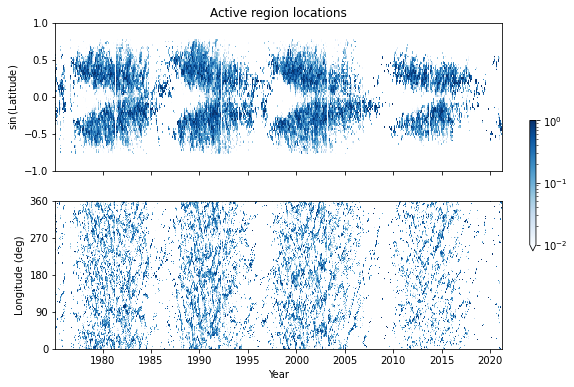

In [17]:
fig, axs = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)

for source, data in all_data.items():
    sinlat = np.sin(np.deg2rad(data.loc['lats']))
    ar_mask = ((np.abs(data.loc['b_feet']) > thresholds[source]) &
               (np.abs(data.loc['lats']) < 50))
    
    ax = axs[0]
    histogram(sinlat, np.linspace(-1, 1, 91), ax, mask=ar_mask)
    ax.set_ylabel('$\sin$(Latitude)')
    ax.set_title('Active region locations')

    ax = axs[1]
    im = histogram(data.loc['lons'], np.linspace(0, 360, 181), ax, mask=ar_mask)
    ax.set_ylabel("Longitude (deg)")    

fig.colorbar(im, ax=axs, shrink=0.4, extend='min')
axs[0].set_xlabel('')
fig.savefig(f'figs/butterfly_ar_{rss}.pdf', bbox_inches='tight')

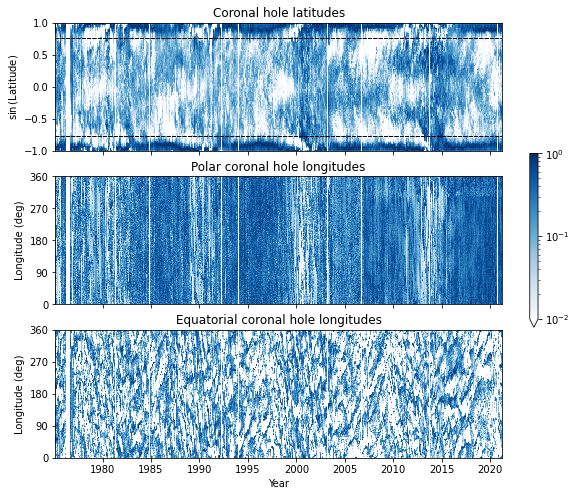

In [21]:
fig, axs = plt.subplots(nrows=3, figsize=(10, 8), sharex=True)

for source, data in all_data.items():
    ar_mask = np.abs(data.loc['b_feet']) > thresholds[source]
    pch_mask = np.abs(data.loc['lats']) > 50

    ax = axs[0]
    sinlat = np.sin(np.deg2rad(data.loc['lats']))
    histogram(sinlat, np.linspace(-1, 1, 101), ax, mask=~ar_mask)
    ax.set_ylabel('$\sin$(Latitude)')
    ax.set_title('Coronal hole latitudes')
    ax.axhline(np.sin(np.deg2rad(50)), color='black', lw=1, linestyle='--')
    ax.axhline(-np.sin(np.deg2rad(50)), color='black', lw=1, linestyle='--')

    ax = axs[1]
    histogram(data.loc['lons'], np.linspace(0, 360, 361), ax, mask=~ar_mask & pch_mask)
    ax.set_ylabel("Longitude (deg)")
    ax.set_title('Polar coronal hole longitudes')
    
    ax = axs[2]
    im = histogram(data.loc['lons'], np.linspace(0, 360, 361), ax, mask=~ar_mask & ~pch_mask)
    ax.set_ylabel("Longitude (deg)")
    ax.set_title('Equatorial coronal hole longitudes')

fig.colorbar(im, ax=axs, shrink=0.4, extend='min')
[ax.set_xlabel('') for ax in axs[0:2]]
fig.savefig(f'figs/butterfly_ch_{rss}.pdf', bbox_inches='tight')